## FX Cross-sectional Momentum - Monthly Frequency

### Literature Review

The profitability of momentum-based trading strategies was first documented by Jegadeesh and Titman (1993) using data for stock markets. 

Their profitability is now very well documented in equities. In FX, however, until recently, there is little evidence on momentum in the cross-section of currencies as large cross-country datasets were rare in the past. __Okunev and White (2003)__, analyse a universe of eight currencies over 20 years, from Janury to June 2000. They find a return of about __6%__ p.a., which is independent of the base currency chosen and the specific trading rule chosen. More recently,  

### Data

In [119]:
###################################
#       Loading Packages          #
###################################
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import glob
from scipy import stats


###################################
#        Imporing Data            #
###################################

#define path
path=r"/Users/valeriyamalenko/Desktop/trading/trading/momentum/data/mecklai-finance/"

#list paths to all usd-base files
files=glob.glob(path +"/usd-*.csv")
 
#open the first file
tb=pd.read_csv(files[0])

#append all other files in the directory to the first file
for i in files[1:]:
    tb1=pd.read_csv(i, header=0)
    tb=tb.append(tb1)
    
tb=tb[['Currency', 'Date', 'SpotDate', 'SpotRate', 'col1']]
tb=tb.drop_duplicates()
tb=tb.reset_index()
tb.drop('index', inplace=True, axis='columns')
tb = tb.rename(columns = {'col1': 'frd1m'})
len(tb.Currency.unique().tolist())

#list paths to usd-term files
files=glob.glob(path +"/*-usd.csv")

#open the first file
tb2=pd.read_csv(files[0])

#append all other files in the directory to the first file
for i in files[1:]:
    tb3=pd.read_csv(i, header=0)
    tb2=tb2.append(tb3)
    
tb2=tb2[['Currency', 'Date', 'SpotDate', 'SpotRate', 'col1']]
tb2=tb2.drop_duplicates()
tb2=tb2.reset_index()
tb2.drop('index', inplace=True, axis='columns')
tb2=tb2.rename(columns = {'col1': 'frd1m'})

#transorming pairs to be quoted against the dollar (e.g. USD/GBP)
tb2.SpotRate=1/tb2.SpotRate
tb2.frd1m=1/tb2.frd1m

a=tb2.Currency.str.split("/")
tb2["Currency"]=a.str[1]+"/"+a.str[0]
len(tb2.Currency.unique().tolist())

#adding usd-term and usd-base dfs
frames=[tb2,tb]
df=pd.concat(frames)
df.rename(columns = {'Date': 'date', 'Currency': 'ccy', 'SpotRate': 'spot'}, inplace = True)

#######################################
#    Cleaning and Inspecting Data     #
#######################################

#convert date to datetime
df.date=pd.to_datetime(df['date'])

#set date to be the index
df=df.set_index('date')

#exclude 2019 data
dt = datetime.datetime(2019, 1, 1)
df = df.iloc[df.index < dt]

df.reset_index().groupby('date').count().sort_values(by='ccy', ascending = False)

#the dataset clearly has a problem: duplicates

df= df.reset_index()  

#drop duplicates
ccy_l=df['ccy'].unique().tolist()
i=ccy_l[0]
df_1=df[df['ccy']==i]
df_1=df_1.drop_duplicates(['date'])

for i in ccy_l[1:]:
    df_2=df[df['ccy']==i]
    df_2=df_2.drop_duplicates(['date'])
    df_1=df_1.append(df_2)
df=df_1

df =df.set_index('date')

#select last day of the month for each month
df=df.loc[df.reset_index().groupby(df.index.to_period('M'))['date'].max()]
len(df) # good!  12*24*8 = 2304

df.reset_index(inplace = True)

In [120]:
######################################
#       Transofrming Data            #
######################################

#Below is included to suppress the warning
pd.options.mode.chained_assignment = None

#1# generate new cols for logs of spot and fwd rates
df['logSpotRate']=np.log(df['spot'])
df['logfwd1m']=np.log(df['frd1m'])

#the warming is because there are missing values at the start of the dataframe; I use only end of month data though

In [121]:
df.head()

,date,ccy,SpotDate,spot,frd1m,logSpotRate,logfwd1m
0,2011-01-31,USD/NZD,02/02/2011,1.295672,1.298701,0.259030,0.261365
1,2011-01-31,USD/AUD,02/02/2011,1.007963,1.011429,0.007931,0.011364
2,2011-01-31,USD/EUR,02/02/2011,0.735456,0.735727,-0.307264,-0.306896
3,2011-01-31,USD/GBP,02/02/2011,0.630438,0.630597,-0.461341,-0.461089
4,2011-01-31,USD/NOK,02/02/2011,5.823600,5.831700,1.761919,1.763309


__Currency excess return.__ Excess monthly returns to a U.S. investor for holding foreign currency k given by 


$rx_{t+1}^2 \equiv i_{t}^k - i_{t} - \bigtriangleup s_{t+1}^k \approx  f_{t}^k - s_{t+1}^k $

where _s_ and _f_ denote the (log) spot and 1-month forward rate (foreign currency unit per USD), respectively.



In [122]:
#2# Shift forward rates 
ret_df = df[['ccy', 'logSpotRate', 'logfwd1m', 'date']]
ret_df = ret_df.pivot_table(index = 'date', columns = ['ccy'])

for i in df.ccy.unique().tolist():
    ret_df[('logfwd1m', i)] =  ret_df[('logfwd1m', i)].shift(1)
ret_df = ret_df[1:]

for i in df.ccy.unique().tolist():
    ret_df[('ret', i)] = ret_df[('logfwd1m', i)] - ret_df[('logSpotRate', i)] 

ret_df = pd.DataFrame(ret_df['ret'].unstack())
ret_df.reset_index(inplace=True)
ret_df.set_index('date', inplace = True)
ret_df.reset_index(inplace=True)
ret_df.rename(columns = {0: 'spot'}, inplace = True)



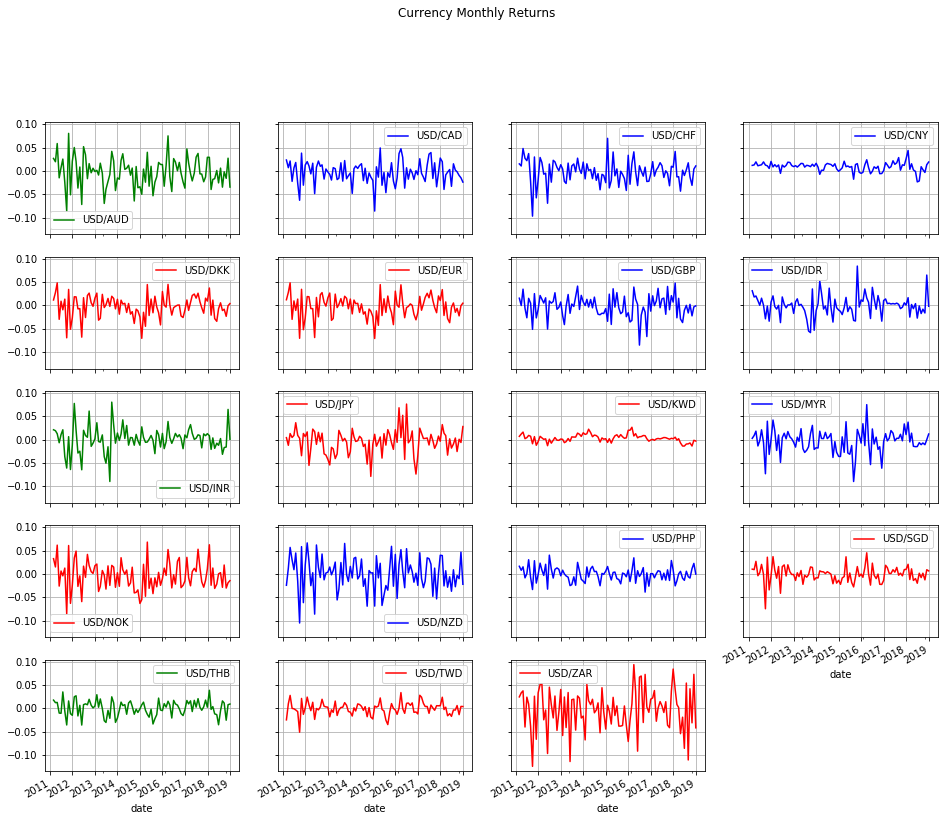

In [123]:
###############################################
#           Visualising the data              #
##############################################

ret_df.pivot(columns = 'ccy', index = 'date', values = 'spot')\
.plot(kind='line', subplots=True, grid=True, title="Currency Monthly Returns",
         sharex=True, sharey=True, legend=True, figsize=(16, 16), layout=(6,4),
        style=['g', 'b', 'b', 
               'b', 'r', 'r', 
               'b', 'b', 'g', 
               'r', 'r', 'b',
               'r', 'b', 'b', 
               'r', 'g', 'r',
               'r', 'r', 'r']);

In [140]:
#######################################################
# Create Momentum Portfolio                           #   
# Measures Based on Past (J) Month Compounded Returns #
#######################################################

N = 4 # Number of portfolios
J = 6 # Formation Period Length: J can be between 3 to 12 months
K = 6 # Holding Period Length: K can be between 3 to 12 months

ret_df = ret_df[['ccy','date','spot']].sort_values(['ccy','date']).set_index('date')

# Calculate rolling cumulative return
# by summing log(1+ret) over the formation period
ret_df['logret']=np.log(1+ret_df['spot'])
umd = ret_df.groupby(['ccy'])['logret'].rolling(J, min_periods=J).sum()
umd = umd.reset_index()
umd['cumret']=np.exp(umd['logret'])-1

In [141]:
########################################
# Formation of 10 Momentum Portfolios  #
########################################

# For each date: assign ranking 1-10 based on cumret
# 1=lowest 10=highest cumret
umd=umd.dropna(axis=0, subset=['cumret'])
umd['momr']=umd.groupby('date')['cumret'].transform(lambda x: pd.qcut(x, N, labels=False))

umd.momr=umd.momr.astype(int)
umd['momr'] = umd['momr']+1
umd['hdate1']=umd['date']+pd.tseries.offsets.MonthBegin(1)
umd['hdate2']=umd['date']+pd.tseries.offsets.MonthEnd(K)
umd=umd.rename(columns={'date':'form_date'})
umd = umd[['ccy','form_date','momr','hdate1','hdate2']]

# join rank and return data together
# note: this step consumes a lot of memory so takes a while
ret_df.reset_index(inplace = True)
_tmp_ret = ret_df[['ccy','date','spot']]
port = pd.merge(_tmp_ret, umd, on=['ccy'], how='inner')
port = port[(port['hdate1']<=port['date']) & (port['date']<=port['hdate2'])]

umd2 = port.sort_values(by=['date','momr','form_date','ccy']).drop_duplicates()
umd3 = umd2.groupby(['date','momr','form_date'])['spot'].mean().reset_index()

# Skip first two years of the sample 
start_yr = umd3['date'].dt.year.min()+2
umd3 = umd3[umd3['date'].dt.year>=start_yr]
umd3 = umd3.sort_values(by=['date','momr'])

# Create one return series per MOM group every month
ewret = umd3.groupby(['date','momr'])['spot'].mean().reset_index()
ewstd = umd3.groupby(['date','momr'])['spot'].std().reset_index()
ewret = ewret.rename(columns={'spot':'ewret'})
ewstd = ewstd.rename(columns={'spot':'ewretstd'})
ewretdat = pd.merge(ewret, ewstd, on=['date','momr'], how='inner')
ewretdat = ewretdat.sort_values(by=['momr'])

# portfolio summary
ewretdat.groupby(['momr'])['ewret'].describe()[['count','mean', 'std']];

In [127]:
#################################
# Long-Short Portfolio Returns  #
#################################

# Transpose portfolio layout to have columns as portfolio returns
ewretdat2 = ewretdat.pivot(index='date', columns='momr', values='ewret')

# Add prefix port in front of each column
ewretdat2 = ewretdat2.add_prefix('port')
ewretdat2 = ewretdat2.rename(columns={'port1':'losers', 'port'+str(N):'winners'})
ewretdat2['long_short'] = ewretdat2['winners'] - ewretdat2['losers']

# Compute Long-Short Portfolio Cumulative Returns
ewretdat3 = ewretdat2
ewretdat3['1+losers']=1+ewretdat3['losers']
ewretdat3['1+winners']=1+ewretdat3['winners']
ewretdat3['1+ls'] = 1+ewretdat3['long_short']

ewretdat3['cumret_winners']=ewretdat3['1+winners'].cumprod()-1
ewretdat3['cumret_losers']=ewretdat3['1+losers'].cumprod()-1
ewretdat3['cumret_long_short']=ewretdat3['1+ls'].cumprod()-1

In [133]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

trace1 = go.Scatter(
    x = ewretdat3.index,
    y = ewretdat3['cumret_winners'],
    name = 'cumret_winners')

trace2 = go.Scatter(
    x = ewretdat3.index,
    y = ewretdat3['cumret_losers'],
    name= 'cumret_losers')

trace3 = go.Scatter(
    x = ewretdat3.index,
    y = ewretdat3['cumret_long_short'],
    name= 'cumret_long_short')

data = [trace1, trace2, trace3]

iplot(data, filename='basic-scatter')

In [135]:
#################################
# Portfolio Summary Statistics  #
################################# 

# Mean 
mom_mean = ewretdat3[['winners', 'losers', 'long_short']].mean().to_frame()
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index()

# T-Value and P-Value
t_losers = pd.Series(stats.ttest_1samp(ewretdat3['losers'],0.0)).to_frame().T
t_winners = pd.Series(stats.ttest_1samp(ewretdat3['winners'],0.0)).to_frame().T
t_long_short = pd.Series(stats.ttest_1samp(ewretdat3['long_short'],0.0)).to_frame().T

t_losers['momr']='losers'
t_winners['momr']='winners'
t_long_short['momr']='long_short'

t_output =pd.concat([t_winners, t_losers, t_long_short])\
    .rename(columns={0:'t-stat', 1:'p-value'})

# Combine mean, t and p
mom_output = pd.merge(mom_mean, t_output, on=['momr'], how='inner')
mom_output

,momr,mean,t-stat,p-value
0,winners,0.000591,0.365268,0.715997
1,losers,-0.002486,-1.115664,0.268328
2,long_short,0.003077,1.850555,0.068394
